# Introduction

In this notebook I perform analysis to assess how similar the left and right-hand side data are to each other, for each user:
1. Time-Lagged Cross Correlation Analysis, which looks at the linear correlation between two signals at different lags. This measure, however, assumes stationarity of the whole time series, i.e., the average does not depend on time. This assumption is most likely not satisfied by our data.
2. Detrended-cross correlation analysis. Here, I consider the max correlation achieved in the analysis (which is performed over different lags). This measure is data-independent, corrects for non-stationarity in the timeseries, which might indeed skew traditional cross-correlation. For reference on the method, see [1] and [2].
3. Coherence Analysis, which allows to see which frequencies interact the most between two signals. However, even in this setting, non-stationary time series might create problems, see [3].
4. Dynamic Time Warping Distance. This, however, is a distance, and as such is problem dependent. It is not very clear how to compare DTWD between BVP and EDA signals.

--- 
*References*

[1] Podobnik, Boris, and H. Eugene Stanley. "Detrended cross-correlation analysis: a new method for analyzing two nonstationary time series." Physical review letters 100.8 (2008): 084102.

[2] Shen, Chenhua. "Analysis of detrended time-lagged cross-correlation between two nonstationary time series." Physics Letters A 379.7 (2015): 680-687.

[3] White, Langford B., and Boualem Boashash. "Cross spectral analysis of nonstationary processes." IEEE Transactions on Information Theory 36.4 (1990): 830-835.

In [1]:
GOING_BACK_SECS = 2

# Data Loading

In [2]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"
bvp_data_base_path: str = "../data.nosync/usilaughs/filtered/*/BVP/*.parquet"

eda_data_paths: list[str] = glob(eda_data_base_path)
acc_data_paths: list[str] = glob(acc_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)
    
   
acc_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
) 
for file in tqdm(acc_data_paths, desc="Loading ACC data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    acc_data[side_name][user_name] = read_parquet(file)

# bvp_data = None


bvp_data_paths: list[str] = glob(bvp_data_base_path)
bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
    'ACC': acc_data,
}
del eda_data
del bvp_data
del acc_data
garbage_collect()

Loading EDA data:   0%|          | 0/67 [00:00<?, ?it/s]

Loading ACC data:   0%|          | 0/68 [00:00<?, ?it/s]

Loading BVP data:   0%|          | 0/68 [00:00<?, ?it/s]

327

## Experiment Info

In [4]:
from sys import path
path.append("../")
from pandas import read_parquet, IndexSlice, concat, DataFrame, Series
from src.utils import slice_user_over_experiment_time
from src.utils.correlation import calculate_correlation_coefficients
from src.utils.plots import bland_altman_plot
from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from time import time
from tqdm.notebook import tqdm
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig, show, title
from numpy import array, asarray, ndarray, mean
from copy import deepcopy

sessions_groupings: dict[str, list[str]] = {
    "baseline": ["baseline_1", "baseline_2", "baseline_3", "baseline_4", "baseline_5"],
    "cognitive_load": ["cognitive_load"],
    "fake_laughter": ["fake"],
    "clapping_hands": ["clapping_hands"],
    "funny_videos": [
        "baby",
        "people_car",
        "stand_up_comedy",
        "himym",
        "cat",
        "penguins",
        "man",
        "bbt",
        "people_falling",
    ],
}


def change_orientation(x: DataFrame) -> DataFrame:
    users = x.index.get_level_values(1).unique()
    event = x.index.get_level_values(0).unique()
    x = array(x)
    x = DataFrame(x, index=users, columns=event).T
    return x


def calculate_mean_difference(x: DataFrame, use_abs: bool = False) -> ndarray:
    data1: Series = x.loc[:, "left"]
    data2: Series = x.loc[:, "right"]
    data1: ndarray = asarray(data1)
    data2: ndarray = asarray(data2)
    if use_abs:
        diff: ndarray = abs(data1 - data2)  # Absolute Difference between data1 and data2
    else:
        diff: ndarray = data1 - data2  # Difference between data1 and data2
    md = mean(diff)
    return md

experimento_info = read_parquet("../../ContinuousLaugh/data.nosync/all_experimento_info_corrected.parquet")

# Checking Stationarity

In [103]:
from typing import Callable
from arch.unitroot import KPSS
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap
from collections import defaultdict
from pandas import Series


def check_stationarity(
    physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]],
    signal: str,
    stationarity_method: Callable = KPSS,
    invert_pvalues: bool = False,
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    statistical_test = {
        side: {
            user: (
                stationarity_method(
                    physiological_data[signal][side][user].iloc[:, 0].values,
                ).pvalue
                if not invert_pvalues
                else 1
                - stationarity_method(
                    physiological_data[signal][side][user].iloc[:, 0].values,
                ).pvalue
            )
            if physiological_data[signal][side][user].iloc[:, 0].values.shape[0] > 0
            else None
            for user in tqdm(user_list, desc="User progress", colour="blue")
        }
        for side in ["left", "right"]
    }

    df_to_save: Series = DataFrame(statistical_test).sort_index().T

    figure(figsize=(30, 2))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=1,
        vmin=0,
        center=0,
        cmap="coolwarm",
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"P-values of {stationarity_method.__name__} test ({signal})")
    savefig(
        f"../visualizations/{stationarity_method.__name__}_pvalues_{signal}.pdf",
        bbox_inches="tight",
    )
    show()


## EDA

In [26]:
from arch.unitroot import DFGLS, KPSS, ADF, PhillipsPerron, ZivotAndrews
signal: str = "EDA"

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

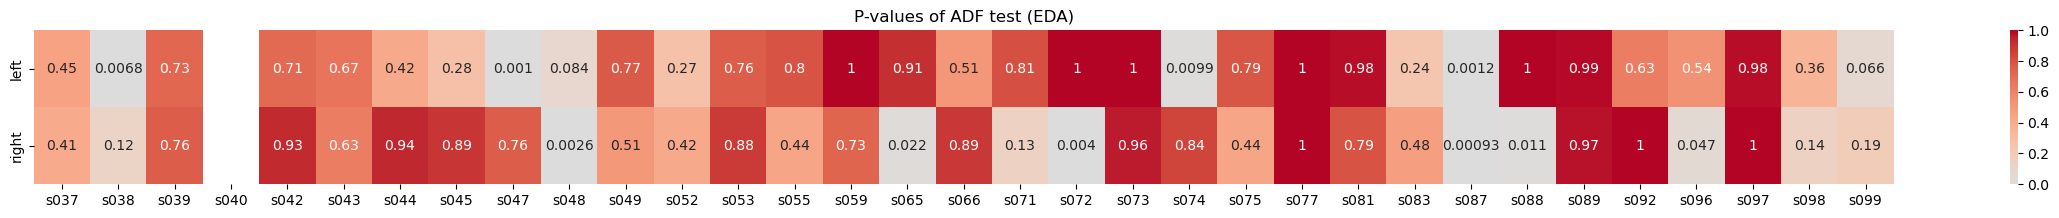

In [ ]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=ADF,
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

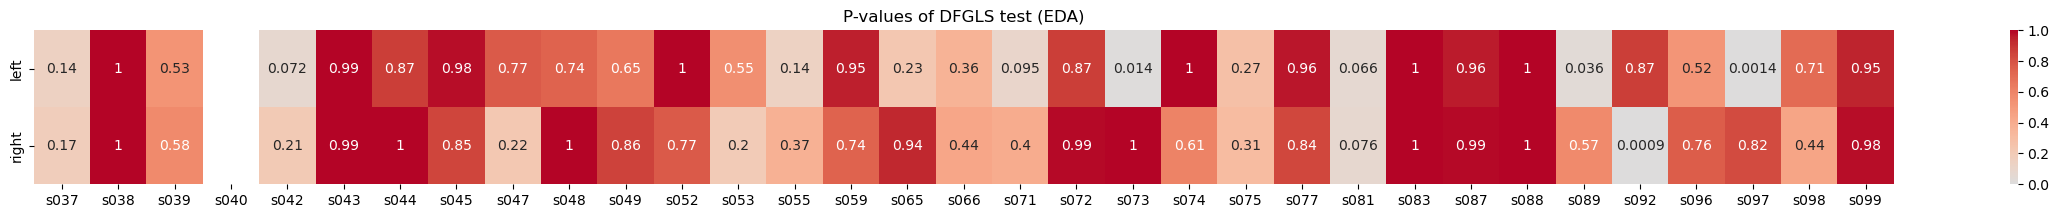

In [13]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=DFGLS,
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

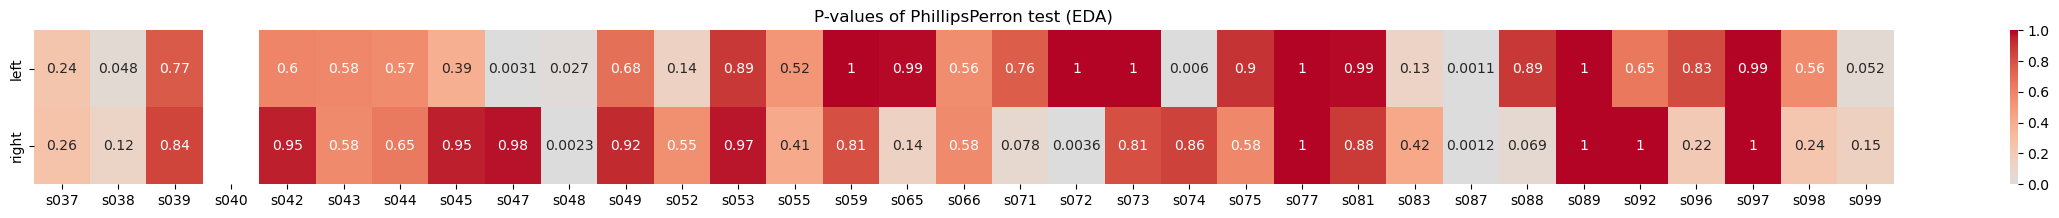

In [14]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=True,
    stationarity_method=PhillipsPerron,
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

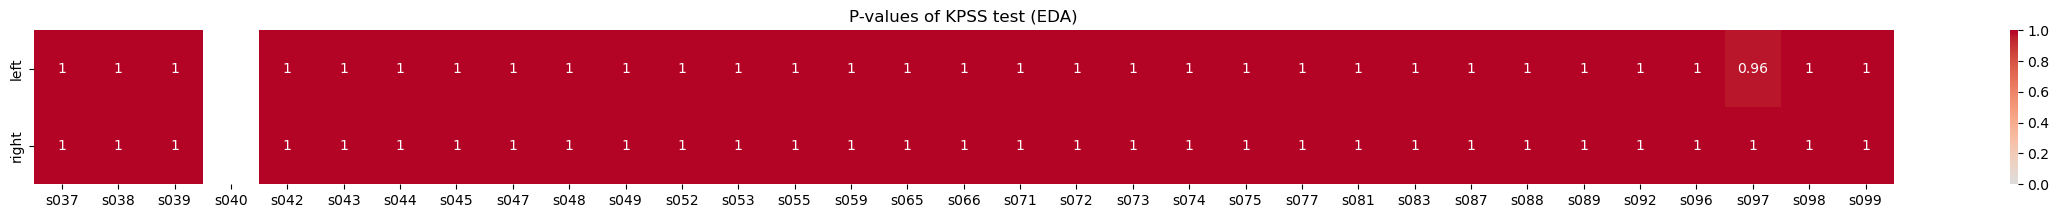

In [15]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=True,
    stationarity_method=KPSS,
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

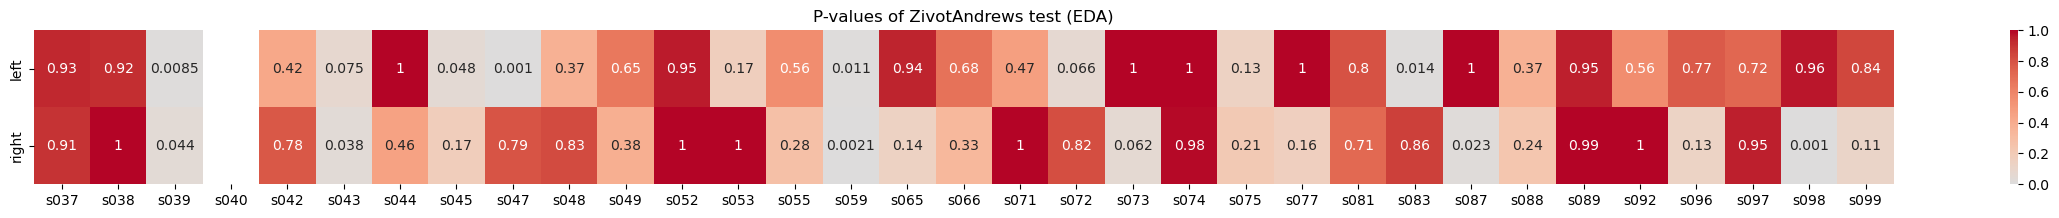

In [27]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=True,
    stationarity_method=ZivotAndrews,
)


## BVP

In [17]:
from arch.unitroot import DFGLS, KPSS, ADF, PhillipsPerron, ZivotAndrews
signal: str = "BVP"

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

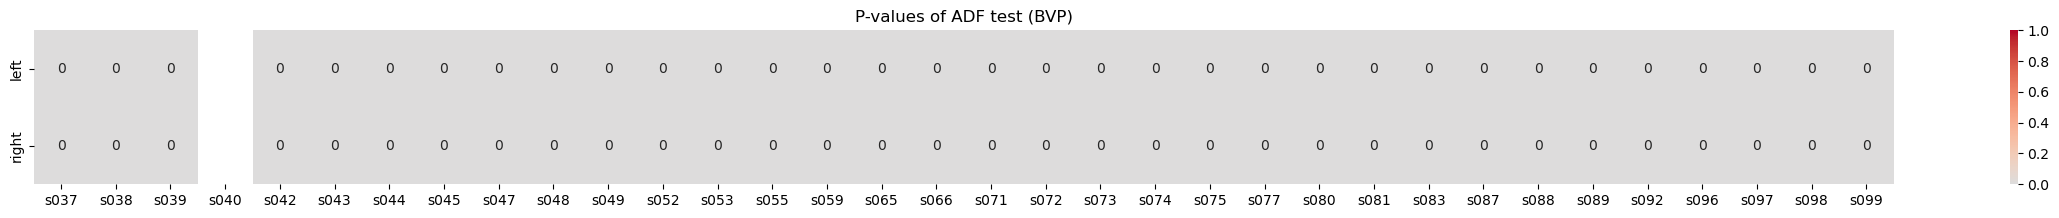

In [23]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=ADF,
)


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

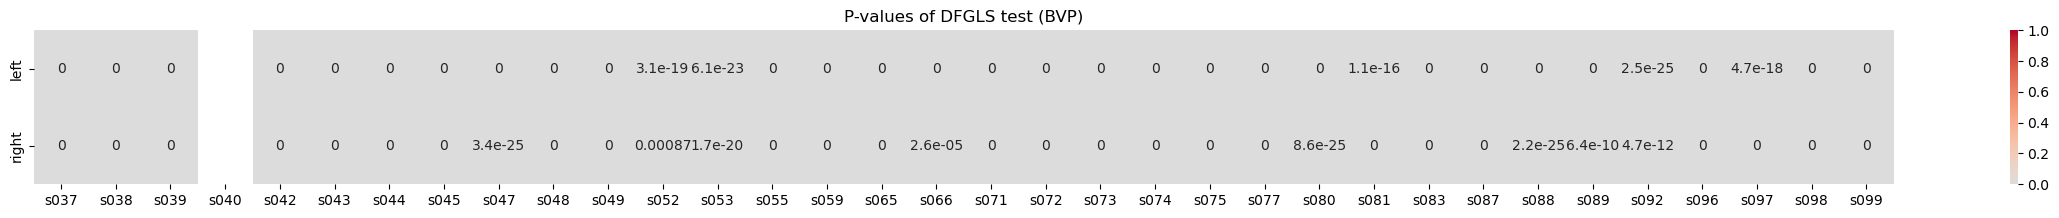

In [19]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=DFGLS,
)


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

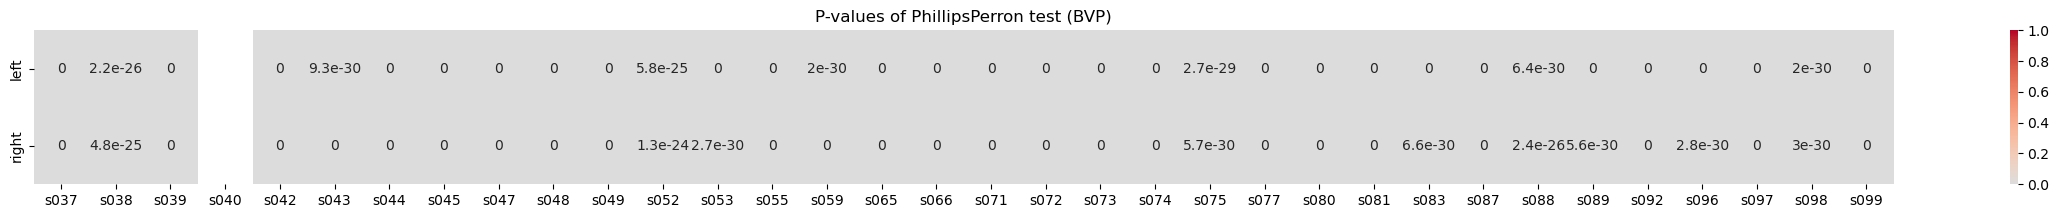

In [24]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=PhillipsPerron,
)


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

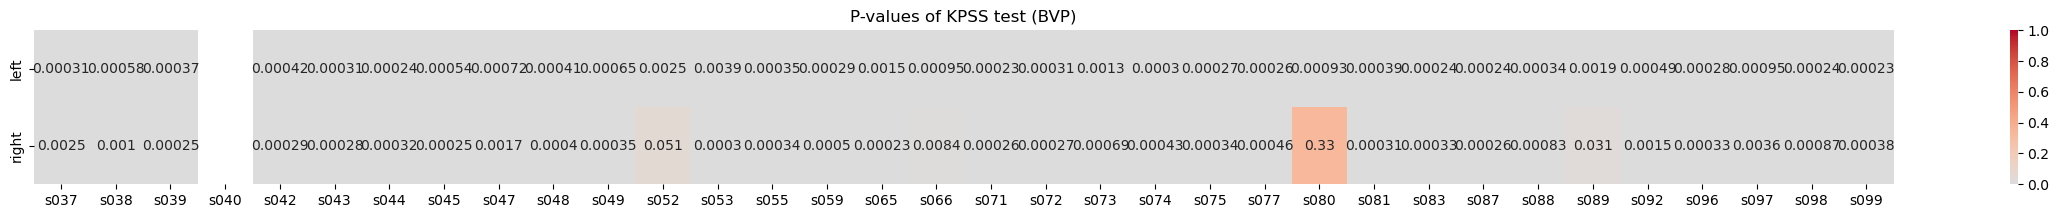

In [21]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=True,
    stationarity_method=KPSS,
)


# Time-Lagged Detrended Cross-Correlation

In [3]:
from sys import path

path.append("../")
from warnings import warn

from joblib import Parallel, delayed
from numpy import nan, ndarray
from pandas import DataFrame
from tqdm.notebook import tqdm

from src.utils.dcca import detrended_correlation
from src.utils.dcca.cross_correlation import cross_correlation
from src.utils.plots import plot_heatmap_boxplot


def time_lagged_cross_correlation_per_user(
    right_side_data: ndarray,
    left_side_data: ndarray,
    time_scale: int | None = None,
    max_time_lag: int | None = None,
    detrended: bool = True,
    n_jobs: int = -1,
    backend: str = "loky",
    **kwargs,
) -> list[float]:
    if max_time_lag is None:
        max_time_lag = len(right_side_data)
    # TODO: implement negative time lags

    if right_side_data.shape[0] == 0 or left_side_data.shape[0] == 0:
        warn(f'No data for current input {kwargs.get("progress_item_name", None)}')
        return []
    time_lags = range(0, max_time_lag)

    if detrended:
        if time_scale is None:
            raise ValueError(
                f"time_scale must be provided for detrended correlation. Given {time_scale}"
            )
        try:
            result = Parallel(n_jobs=n_jobs, backend=backend)(
                delayed(detrended_correlation)(
                    x=right_side_data,
                    y=left_side_data,
                    time_scale=time_scale,
                    time_lag=time_lag,
                )
                for time_lag in tqdm(
                    time_lags,
                    desc=f'Calculating detrended cross correlation {kwargs.get("progress_item_name", None)}',
                    colour=kwargs.get("tqdm_color", "green"),
                )
            )
        except ValueError as e:
            warn(
                f"{right_side_data.shape=}, {left_side_data.shape=}, {time_scale=}, {time_lags=}"
            )
            return nan
        return result
    else:
        warn("Calculation is not parallel. n_jobs ignored.")
        return [
            cross_correlation(x=right_side_data, y=left_side_data, time_lag=time_lag)
            for time_lag in tqdm(
                time_lags,
                desc=f'Calculating cross correlation {kwargs.get("progress_item_name", None)}',
                colour=kwargs.get("tqdm_color", "green"),
            )
        ]


def perform_correlation(
    physiological_data: dict,
    signal: str,
    time_scale: int | None = None,
    detrended: bool = True,
    measure_name: str = "max dcca",
    max_time_lag: int = 200,
    n_jobs: int = -1,
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))
    dccas = {
        user: time_lagged_cross_correlation_per_user(
            right_side_data=physiological_data[signal]["right"][user].iloc[:, 0].values,
            left_side_data=physiological_data[signal]["left"][user].iloc[:, 0].values,
            time_scale=time_scale,
            detrended=detrended,
            max_time_lag=max_time_lag,
            n_jobs=n_jobs,
            progress_item_name=user,
        )
        for user in tqdm(user_list, desc="User progress", colour="blue")
    }

    max_dccas = {
        user: max(dcca) if len(dcca) > 0 else nan for user, dcca in dccas.items()
    }

    plot_heatmap_boxplot(data=max_dccas, measure_name=measure_name, vmax=1, vmin=-1, center=0, signal=signal)


## EDA

### Per-user

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

Calculating detrended cross correlation s052:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s092:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s065:   0%|          | 0/64 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_13634/396586814.py:31: UserWarning: No data for current input s040
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating detrended cross correlation s081:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s042:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s075:   0%|          | 0/64 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Calculating detrended cross correlation s048:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s071:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s072:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s074:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s088:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s098:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s083:   0%|          | 0/64 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Calculating detrended cross correlation s059:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s087:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s049:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s099:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s073:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s037:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s047:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s039:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s089:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s066:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s038:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s053:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s044:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s055:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s077:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s043:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s096:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s045:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation s097:   0%|          | 0/64 [00:00<?, ?it/s]

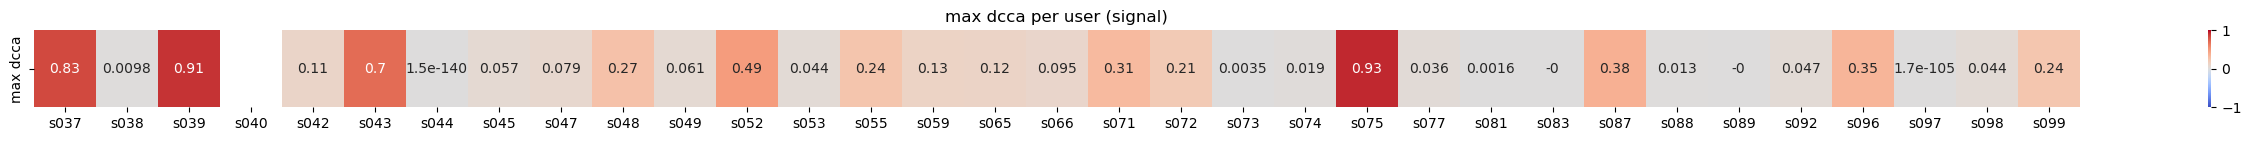

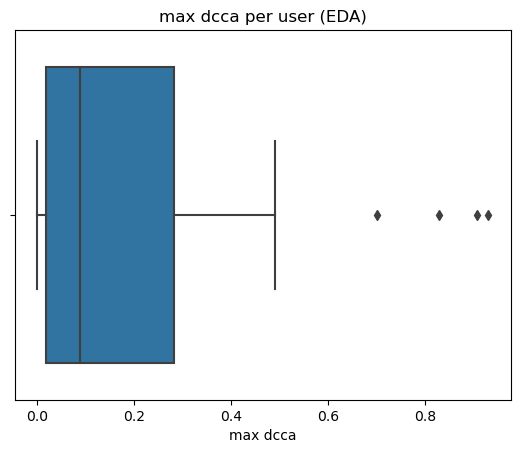

In [6]:
signal: str = "EDA"
time_scale: int = 20
perform_correlation(
    physiological_data=physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=True,
    max_time_lag=int(32*GOING_BACK_SECS),
    measure_name="max dcca",
)


### Per-event and per-user

In [7]:
def perform_correlation(
    physiological_data: dict,
    signal: str,
    data_name: str,
    time_scale: int | None = None,
    max_time_lag: int = 200,
    detrended: bool = True,
    measure_name: str = "max dcca",
    n_jobs: int = -1,
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))
    # physiological_data[signal][side][user]
    #             .iloc[:, [0]]
    #             .groupby(axis=0, level=0)
    #             .parallel_apply(lambda x: stationarity_method(x.values).pvalue)
    #             .to_dict()

    dccas = {
        user: {
            session_name: time_lagged_cross_correlation_per_user(
                right_side_data=physiological_data[signal]["right"][user][session_name].iloc[:,0].values,
                left_side_data=physiological_data[signal]["left"][user][session_name].iloc[:,0].values,
                time_scale=time_scale,
                detrended=detrended,
                max_time_lag=max_time_lag,
                n_jobs=n_jobs,
                backend='threading',
                progress_item_name=f"{user}_{session_name}",
            )
            for session_name in list(
                set(
                    physiological_data[signal]["right"][user].keys()
                )
                & set(
                    physiological_data[signal]["left"][user].keys()
                )
            )
        }
        for user in tqdm(user_list, desc="User progress", colour="blue")
    }
    # from numpy import mean
    # max_dccas = {
    #     user: {
    #         session_name: max(session_dcca) if len(session_dcca) > 0 else nan
    #         for session_name, session_dcca in user_dcca.items()
    #     }
    #     for user, user_dcca in dccas.items()
    # }
    # avg_max_dccas = {
    #     user: mean(max_dcca)
    #     for user, user_dcca in max_dccas.items()
    #     for session_name, max_dcca in user_dcca.items()
    # }
    try:
        plot_heatmap_boxplot(
            data=max_dccas,
            measure_name=measure_name,
            nested=True,
            vmax=1,
            vmin=-1,
            center=0,
            data_name=data_name,
        )
        return dccas
    except:
        return dccas

from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    inverted: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    if inverted:
        df_to_save= df_to_save.T
    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

    if df_to_save.shape[1] > 1:
        new_df = DataFrame(columns=['Value', 'Session'])
        for idx_uniques in df_to_save.index.unique():
            intermediate1 = df_to_save.loc[idx_uniques]
            intermediate2 = [idx_uniques for _ in range(len(intermediate1))]
            intermediate3 = DataFrame.from_dict({'Value': intermediate1, 'Session': intermediate2})
            new_df = new_df.append(intermediate3)
        boxplot(x='Value', y='Session', data=new_df)
    else:
        boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

In [8]:
from warnings import warn
physiological_data_w_events = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
signal: str = 'EDA'
selected_keys = ['cognitive_load', 'baseline_1']
for side in ['left', 'right']:
    for user in experimento_info.index.get_level_values(0).unique():
        if user not in physiological_data[signal][side]:
            warn(f'User {user} not in {signal} {side} data')
            continue
        user_data: DataFrame = physiological_data[signal][side][user]
        user_experiment_info = experimento_info.loc[user]
        for event in user_experiment_info.index:
            if event in selected_keys:
                start, end = user_experiment_info.loc[event, ['start', 'end']]
                physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
            else:
                continue

NameError: name 'experimento_info' is not defined

In [108]:
signal: str = "EDA"
time_scale: int = 20
dcca = perform_correlation(
    physiological_data=physiological_data_w_events,
    signal=signal,
    time_scale=time_scale,
    detrended=True,
    max_time_lag=int(32*0.5),
    measure_name="max dcca",
    data_name='mwc2022',
    n_jobs=-1,
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

Calculating detrended cross correlation s052_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s052_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s043_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s043_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s037_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s037_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s038_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s038_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s072_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s072_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s075_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s075_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s066_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s066_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s053_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s053_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s077_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s077_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s045_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s045_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s047_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s047_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s074_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s074_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s044_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s044_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s048_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s048_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s055_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s055_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s098_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s098_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s083_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s083_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s089_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s089_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s087_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s087_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s099_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s099_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s039_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s039_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s042_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s042_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s097_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s097_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s081_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s081_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s088_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s088_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s073_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s073_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s096_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s096_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/396586814.py:31: UserWarning: No data for current input s040_baseline_1
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/396586814.py:31: UserWarning: No data for current input s040_cognitive_load
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating detrended cross correlation s065_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s065_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s071_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s071_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s059_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s059_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s092_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s092_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s049_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s049_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

In [109]:
max_dccas = {
        user: {
            session_name: max(session_dcca) if len(session_dcca) > 0 else nan
            for session_name, session_dcca in user_dcca.items()
        }
        for user, user_dcca in dcca.items()
}

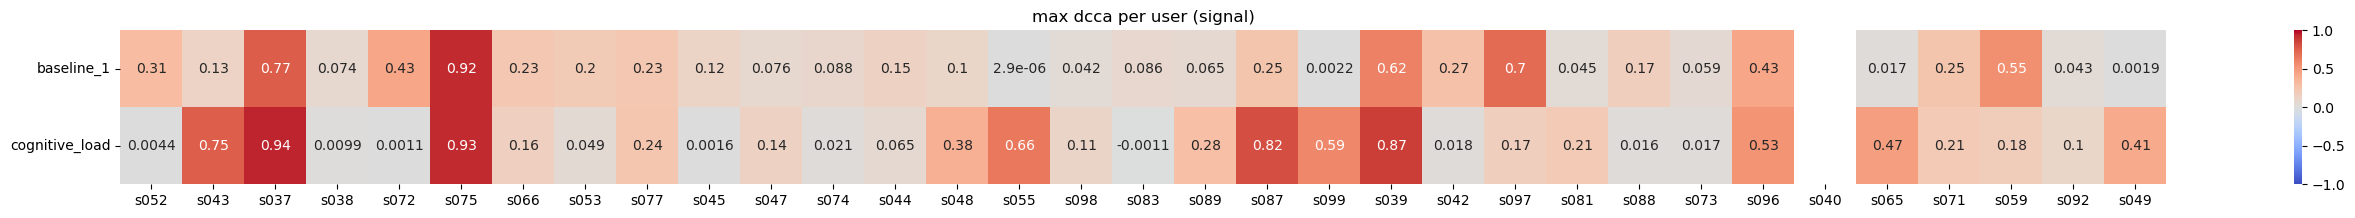

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/2135341668.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/2135341668.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)


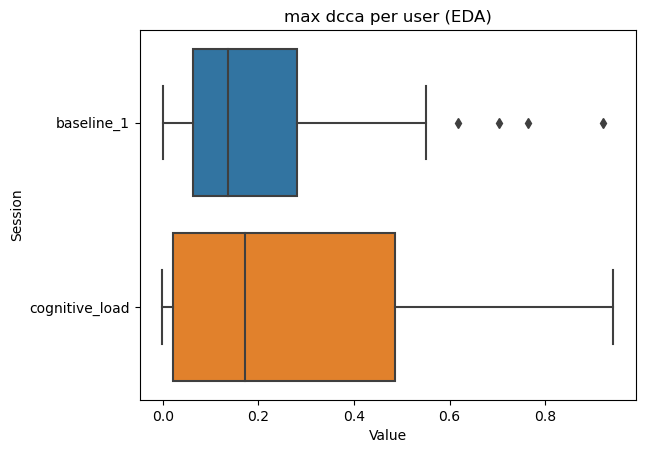

In [110]:
plot_heatmap_boxplot(
            data=max_dccas,
            inverted=True,
            measure_name='max dcca',
            nested=True,
            vmax=1,
            vmin=-1,
            center=0,
            signal=signal,
            data_name='usilaughs',
        )

<Axes: >

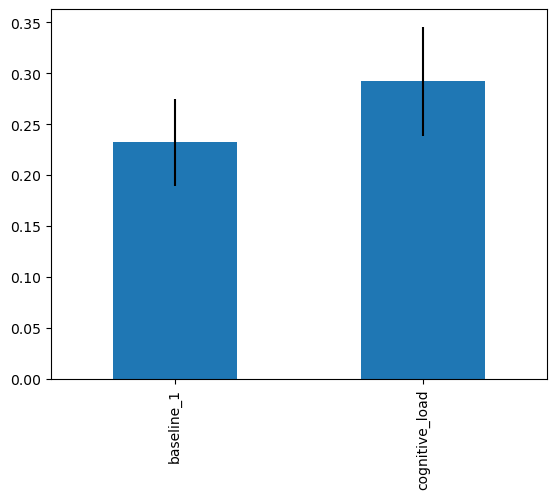

In [111]:
from numpy import sqrt
test = DataFrame(max_dccas)
means = test.mean(axis=1)
stds = test.std(axis=1)
ses = stds / sqrt(len(test.columns))
means.plot(yerr=ses, kind='bar')

## BVP

### Per user

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

Calculating detrended cross correlation s074:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s071:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s097:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s048:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s039:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s052:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s038:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s066:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s098:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s096:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s072:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s042:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s037:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s092:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s044:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s081:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s065:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s080:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s047:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s073:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s049:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s088:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s059:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s075:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s045:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s083:   0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:31: UserWarning: No data for current input s040
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating detrended cross correlation s043:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s077:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s089:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s087:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s055:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s053:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s099:   0%|          | 0/200 [00:00<?, ?it/s]

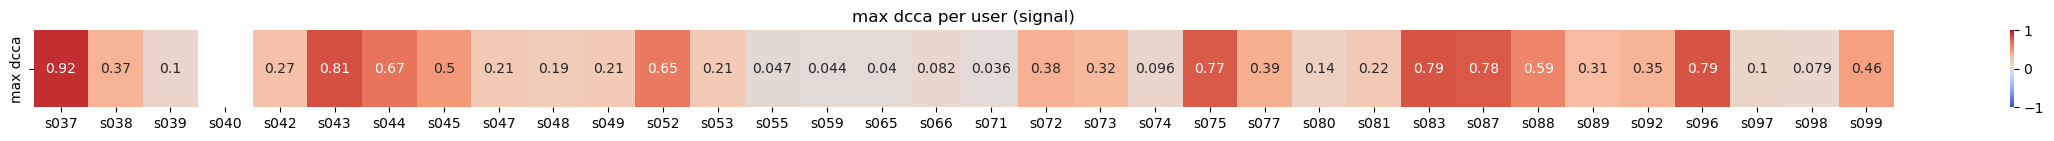

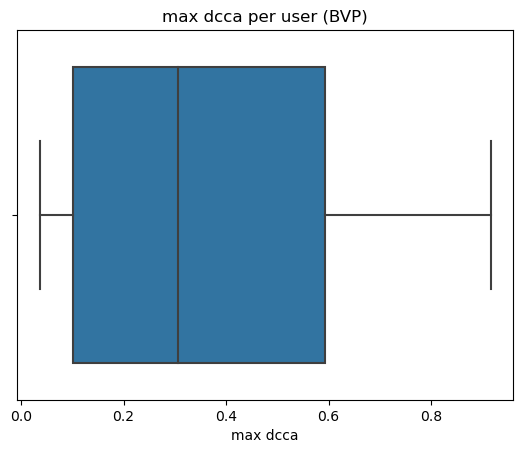

In [5]:
signal: str = "BVP"
time_scale: int = 20
perform_correlation(
    physiological_data=physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=True,
    measure_name="max dcca",
    n_jobs=-1,
)


### Per-event and per-user

In [133]:
def perform_correlation(
    physiological_data: dict,
    signal: str,
    data_name: str,
    time_scale: int | None = None,
    max_time_lag: int = 200,
    detrended: bool = True,
    measure_name: str = "max dcca",
    n_jobs: int = -1,
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))
    # physiological_data[signal][side][user]
    #             .iloc[:, [0]]
    #             .groupby(axis=0, level=0)
    #             .parallel_apply(lambda x: stationarity_method(x.values).pvalue)
    #             .to_dict()

    dccas = {
        user: {
            session_name: time_lagged_cross_correlation_per_user(
                right_side_data=physiological_data[signal]["right"][user][session_name].iloc[:,0].values,
                left_side_data=physiological_data[signal]["left"][user][session_name].iloc[:,0].values,
                time_scale=time_scale,
                detrended=detrended,
                max_time_lag=max_time_lag,
                n_jobs=n_jobs,
                backend='threading',
                progress_item_name=f"{user}_{session_name}",
            )
            for session_name in list(
                set(
                    physiological_data[signal]["right"][user].keys()
                )
                & set(
                    physiological_data[signal]["left"][user].keys()
                )
            )
        }
        for user in tqdm(user_list, desc="User progress", colour="blue")
    }
    # from numpy import mean
    # max_dccas = {
    #     user: {
    #         session_name: max(session_dcca) if len(session_dcca) > 0 else nan
    #         for session_name, session_dcca in user_dcca.items()
    #     }
    #     for user, user_dcca in dccas.items()
    # }
    # avg_max_dccas = {
    #     user: mean(max_dcca)
    #     for user, user_dcca in max_dccas.items()
    #     for session_name, max_dcca in user_dcca.items()
    # }
    try:
        plot_heatmap_boxplot(
            data=max_dccas,
            measure_name=measure_name,
            nested=True,
            vmax=1,
            vmin=-1,
            center=0,
            data_name=data_name,
        )
        return dccas
    except:
        return dccas

from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    inverted: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    if inverted:
        df_to_save= df_to_save.T
    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

    if df_to_save.shape[1] > 1:
        new_df = DataFrame(columns=['Value', 'Session'])
        for idx_uniques in df_to_save.index.unique():
            intermediate1 = df_to_save.loc[idx_uniques]
            intermediate2 = [idx_uniques for _ in range(len(intermediate1))]
            intermediate3 = DataFrame.from_dict({'Value': intermediate1, 'Session': intermediate2})
            new_df = new_df.append(intermediate3)
        boxplot(x='Value', y='Session', data=new_df)
    else:
        boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

In [134]:
from warnings import warn
physiological_data_w_events = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
signal: str = 'BVP'
selected_keys = ['cognitive_load', 'baseline_1']
for side in ['left', 'right']:
    for user in experimento_info.index.get_level_values(0).unique():
        if user not in physiological_data[signal][side]:
            warn(f'User {user} not in {signal} {side} data')
            continue
        user_data: DataFrame = physiological_data[signal][side][user]
        user_experiment_info = experimento_info.loc[user]
        for event in user_experiment_info.index:
            if event in selected_keys:
                start, end = user_experiment_info.loc[event, ['start', 'end']]
                physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
            else:
                continue

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/1335996214.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/1335996214.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/1335996214.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
 

In [135]:
signal: str = "BVP"
time_scale: int = 20
dcca = perform_correlation(
    physiological_data=physiological_data_w_events,
    signal=signal,
    time_scale=time_scale,
    detrended=True,
    max_time_lag=int(32*0.5),
    measure_name="max dcca",
    data_name='mwc2022',
    n_jobs=-1,
)


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

Calculating detrended cross correlation s052_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s052_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s043_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/dcca/__init__.py:115: RuntimeWarning: overflow encountered in multiply
  numerator = sum(x_box_residuals * y_box_residuals, axis=1)


Calculating detrended cross correlation s043_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s037_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s037_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s038_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s038_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s072_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s072_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s075_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s075_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s066_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s066_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s053_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s053_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s077_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s077_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s045_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s045_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s047_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s047_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s074_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s074_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s044_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s044_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s048_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s048_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s055_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s055_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s098_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s098_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s083_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s083_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s089_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s089_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s080_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s080_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Calculating detrended cross correlation s087_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s087_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s099_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s099_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s039_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s039_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s042_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s042_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s097_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s097_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s081_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s081_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s088_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s088_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s073_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s073_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s096_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s096_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/396586814.py:31: UserWarning: No data for current input s040_baseline_1
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/396586814.py:31: UserWarning: No data for current input s040_cognitive_load
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating detrended cross correlation s065_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s065_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s071_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s071_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s059_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s059_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s092_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s092_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s049_baseline_1:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating detrended cross correlation s049_cognitive_load:   0%|          | 0/16 [00:00<?, ?it/s]

In [136]:
max_dccas = {
        user: {
            session_name: max(session_dcca) if len(session_dcca) > 0 else nan
            for session_name, session_dcca in user_dcca.items()
        }
        for user, user_dcca in dcca.items()
}

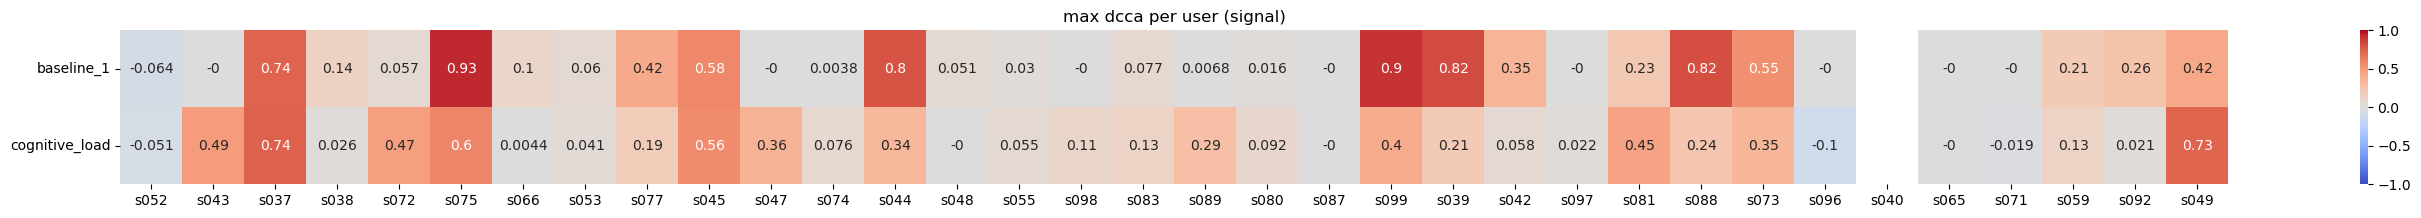

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/2135341668.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/2135341668.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)


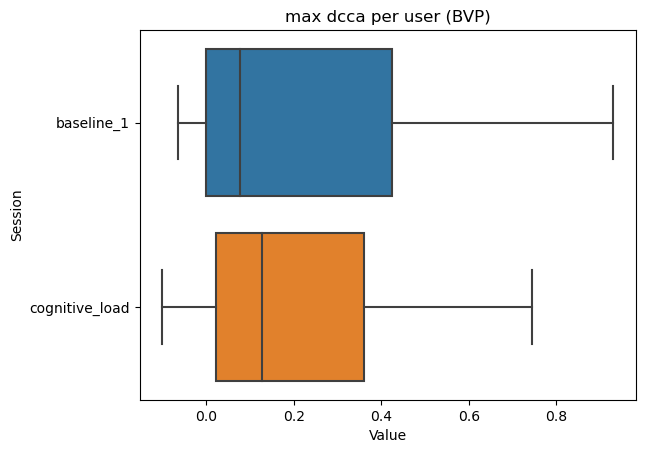

In [137]:
plot_heatmap_boxplot(
            data=max_dccas,
            inverted=True,
            measure_name='max dcca',
            nested=True,
            vmax=1,
            vmin=-1,
            center=0,
            signal=signal,
            data_name='usilaughs',
        )

<Axes: >

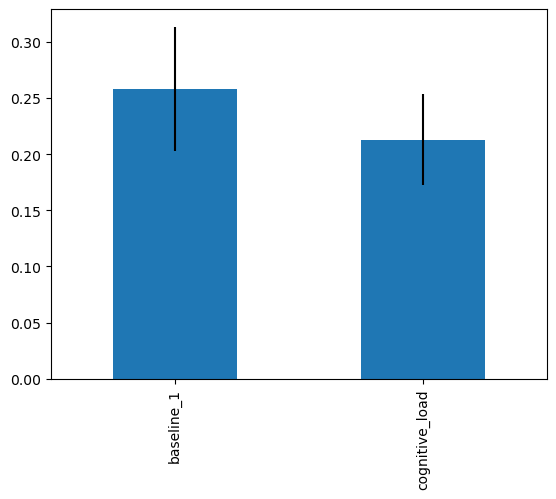

In [138]:
from numpy import sqrt
test = DataFrame(max_dccas)
means = test.mean(axis=1)
stds = test.std(axis=1)
ses = stds / sqrt(len(test.columns))
means.plot(yerr=ses, kind='bar')

# Time-Lagged Cross-Correlation

## EDA

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:61: UserWarning: Calculation is not parallel. n_jobs ignored.
  warn("Calculation is not parallel. n_jobs ignored.")


Calculating cross correlation s074:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s071:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s097:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s048:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s039:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s052:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s038:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s066:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s098:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s096:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s072:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s042:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s037:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s092:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s044:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s081:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s065:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s047:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s073:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s049:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s088:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s059:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s075:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s045:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s083:   0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:31: UserWarning: No data for current input s040
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating cross correlation s043:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s077:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s089:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s087:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s055:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s053:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s099:   0%|          | 0/200 [00:00<?, ?it/s]

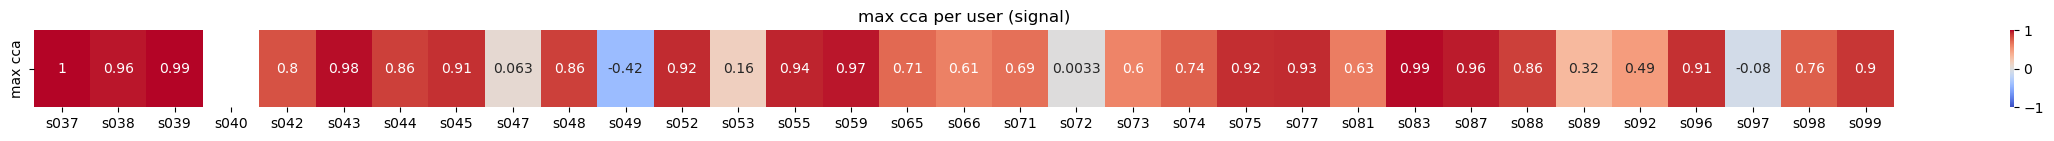

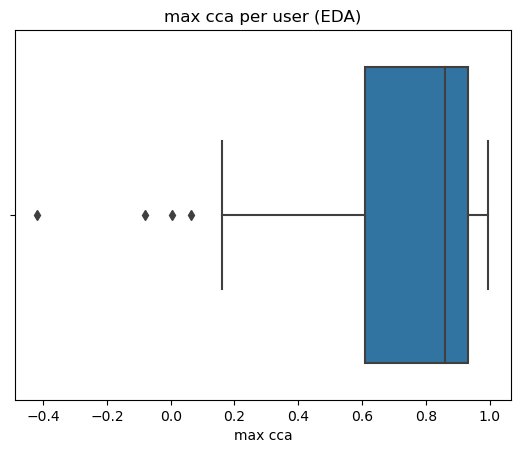

In [6]:
signal: str = "EDA"
time_scale: int = 20
perform_correlation(
    physiological_data=physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=False,
    measure_name="max cca",
)


## BVP

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:61: UserWarning: Calculation is not parallel. n_jobs ignored.
  warn("Calculation is not parallel. n_jobs ignored.")


Calculating cross correlation s074:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s071:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s097:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s048:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s039:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s052:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s038:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s066:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s098:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s096:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s072:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s042:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s037:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s092:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s044:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s081:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s065:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s080:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s047:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s073:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s049:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s088:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s059:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s075:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s045:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s083:   0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:31: UserWarning: No data for current input s040
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating cross correlation s043:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s077:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s089:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s087:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s055:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s053:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s099:   0%|          | 0/200 [00:00<?, ?it/s]

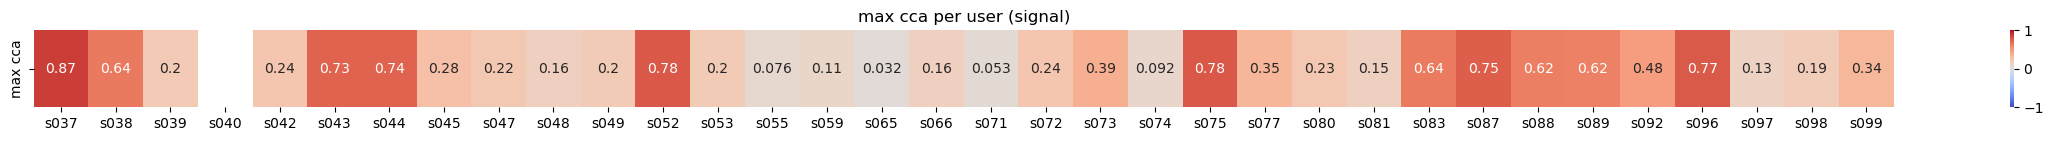

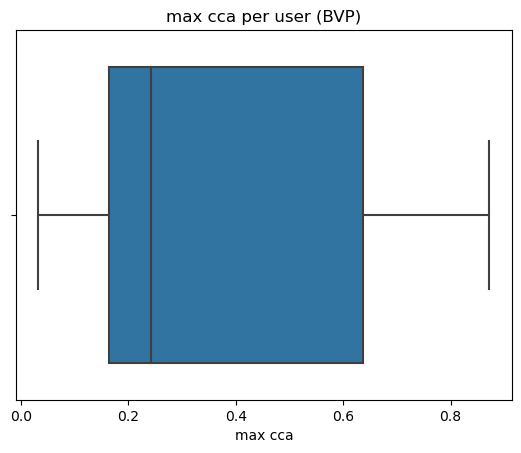

In [7]:
signal: str = "BVP"
time_scale: int = 20
perform_correlation(
    physiological_data=physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=False,
    measure_name="max cca",
)


# Dynamic Time Warping

In [112]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sys import path
path.append("../")
from src.utils.plots import plot_heatmap_boxplot

In [113]:
def run_dtw_calculation(physiological_data: dict, signal: str, n_jobs: int = -1, **kwargs):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    # Define a function that takes in a user and computes the DTW distance
    def compute_dtw(user, physiological_data, signal):
        x = physiological_data[signal]["right"][user].iloc[:, 0].values.reshape(-1, 1)
        y = physiological_data[signal]["left"][user].iloc[:, 0].values.reshape(-1, 1)
        return user, fastdtw(x=x, y=y, dist=kwargs.get("distance", euclidean))[0]

    # Use Parallel and delayed to run the function in parallel
    dtws = Parallel(n_jobs=n_jobs)(
        delayed(compute_dtw)(user, physiological_data, signal)
        for user in tqdm(user_list, desc="User progress", colour="blue")
    )

    # Convert the results to a dictionary
    return dict(dtws)


## EDA

### Per user

In [32]:
signal: str = "EDA"
dtws = run_dtw_calculation(physiological_data=physiological_data, signal=signal, n_jobs=1)

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

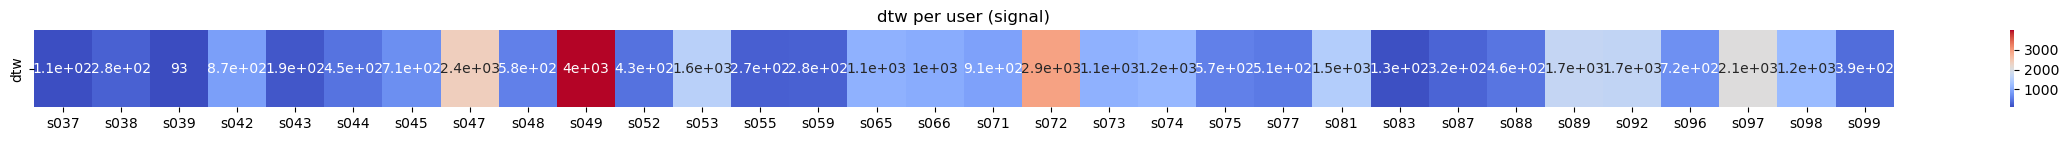

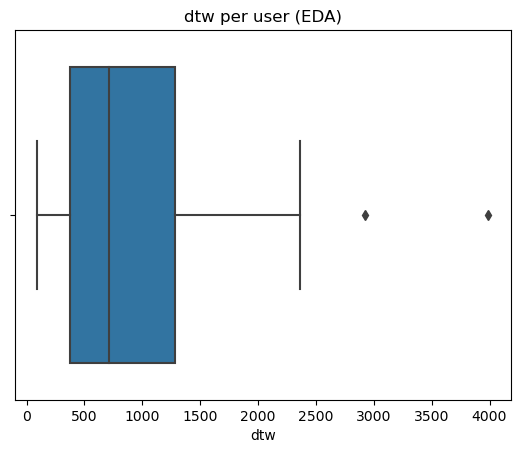

In [33]:
dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
plot_heatmap_boxplot(
    data=dtws, signal=signal, measure_name="dtw", vmax=None, vmin=None, center=None
)


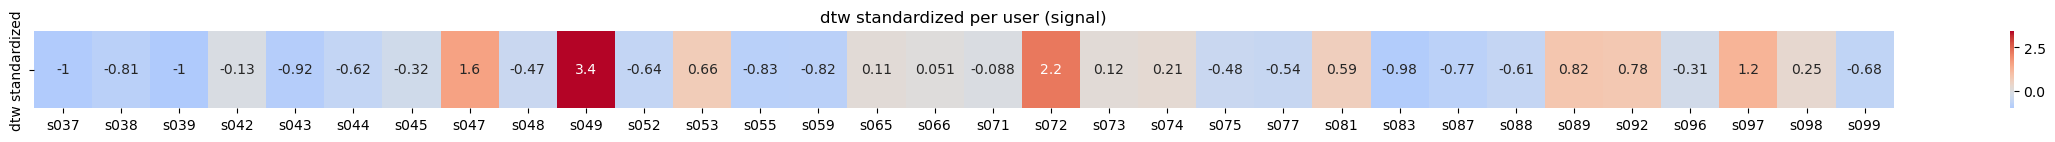

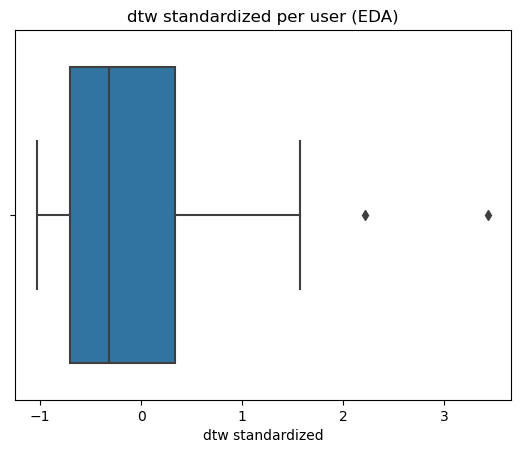

In [34]:
from numpy import nanmean, nanstd

dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
dtws_stand = {
    user: (dtw - nanmean(list(dtws.values()))) / nanstd(list(dtws.values()))
    for user, dtw in dtws.items()
}
plot_heatmap_boxplot(
    data=dtws_stand,
    signal=signal,
    measure_name="dtw standardized",
    vmax=None,
    vmin=None,
    center=0,
)


### Per event and per user

In [114]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sys import path
path.append("../")
from src.utils.plots import plot_heatmap_boxplot

def run_dtw_calculation(
    physiological_data: dict, signal: str, n_jobs: int = -1, **kwargs
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    # Define a function that takes in a user and computes the DTW distance
    def compute_dtw(user, physiological_data, signal, session_name):
        x = (
            physiological_data[signal]["right"][user][session_name]
            .values.reshape(-1, 1)
        )
        y = (
            physiological_data[signal]["left"][user][session_name]
            .values.reshape(-1, 1)
        )
        return user, session_name, fastdtw(x=x, y=y, dist=kwargs.get("distance", euclidean))[0]

    # Use Parallel and delayed to run the function in parallel
    dtws = Parallel(n_jobs=n_jobs, backend='threading')(
        delayed(compute_dtw)(user, physiological_data, signal, session_name)
        for user in tqdm(user_list, desc="User progress", colour="blue")
        for session_name in tqdm(list(
            set(physiological_data[signal]["right"][user].keys())
            & set(physiological_data[signal]["left"][user].keys())
        ), desc='Session progress', colour='green')
    )

    # Convert the results to a dictionary
    return dtws


In [115]:
from warnings import warn
physiological_data_w_events = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
signal: str = 'EDA'
selected_keys = ['cognitive_load', 'baseline_1']
for side in ['left', 'right']:
    for user in experimento_info.index.get_level_values(0).unique():
        if user not in physiological_data[signal][side]:
            warn(f'User {user} not in {signal} {side} data')
            continue
        user_data: DataFrame = physiological_data[signal][side][user]
        user_experiment_info = experimento_info.loc[user]
        for event in user_experiment_info.index:
            if event in selected_keys:
                start, end = user_experiment_info.loc[event, ['start', 'end']]
                physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
            else:
                continue

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/994210659.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/994210659.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/994210659.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ph

In [116]:
signal: str = "EDA"
dtws = run_dtw_calculation(
    physiological_data=physiological_data_w_events, signal=signal, n_jobs=-1
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

In [124]:
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    inverted: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    if inverted:
        df_to_save = df_to_save.T
    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()
    if df_to_save.shape[1] > 1:
        new_df = DataFrame(columns=['Value', 'Session'])
        for idx_uniques in df_to_save.index.unique():
            intermediate1 = df_to_save.loc[idx_uniques]
            intermediate2 = [idx_uniques for _ in range(len(intermediate1))]
            intermediate3 = DataFrame.from_dict({'Value': intermediate1, 'Session': intermediate2})
            new_df = new_df.append(intermediate3)
        boxplot(x='Value', y='Session', data=new_df)
    else:
        boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

new_dtws = defaultdict(dict)
for user, session_name, dtw in dtws:
    new_dtws[user][session_name] = dtw

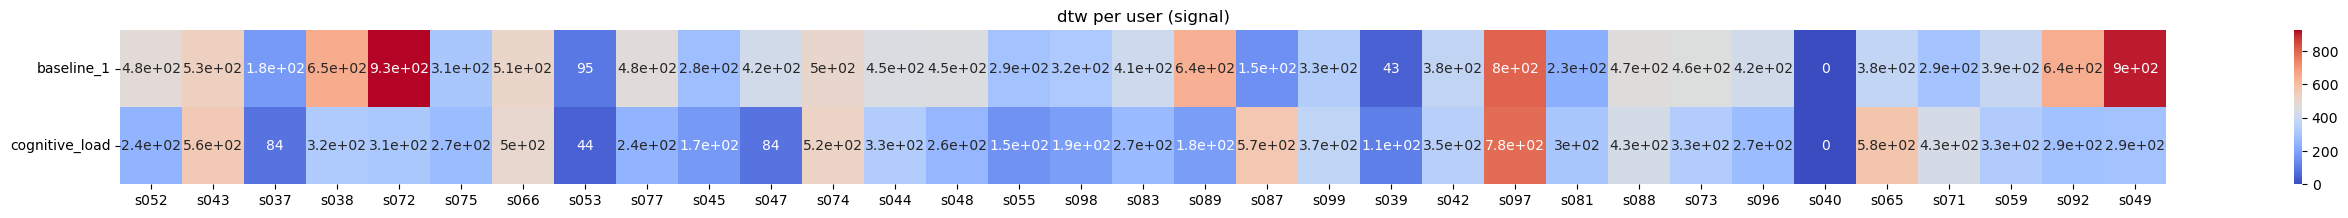

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/2508330802.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/2508330802.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)


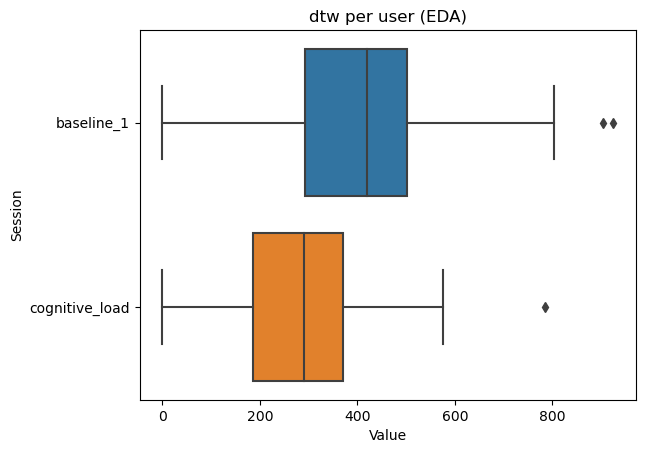

In [125]:


plot_heatmap_boxplot(
            data=new_dtws,
            signal=signal,
            measure_name="dtw",
            nested=True,
            vmax=None,
            vmin=None,
            center=None,
            inverted=True,
            data_name="usilaughs",
        )

<Axes: >

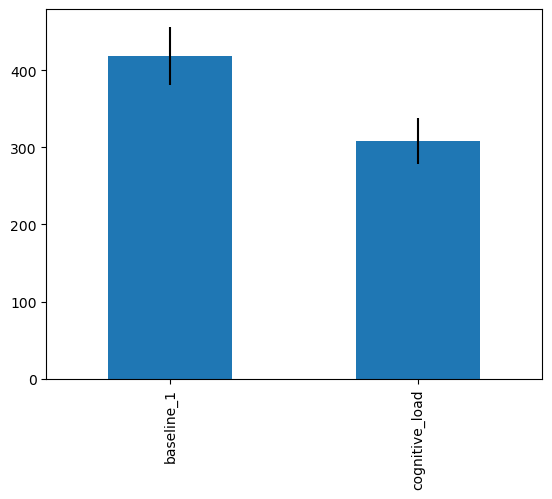

In [126]:
from numpy import sqrt
test = DataFrame(new_dtws)
means = test.mean(axis=1)
stds = test.std(axis=1)
ses = stds / sqrt(len(test.columns))
means.plot(yerr=ses, kind='bar')

## BVP

### Per user

In [ ]:
signal: str = "BVP"
dtws = run_dtw_calculation(physiological_data=physiological_data, signal=signal, n_jobs=-1)

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


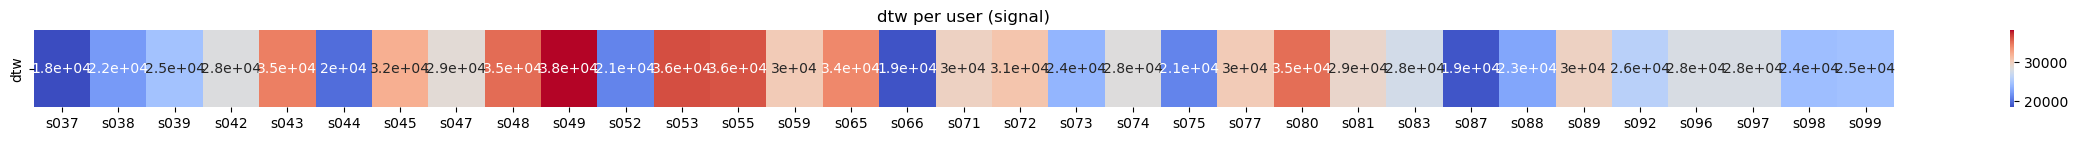

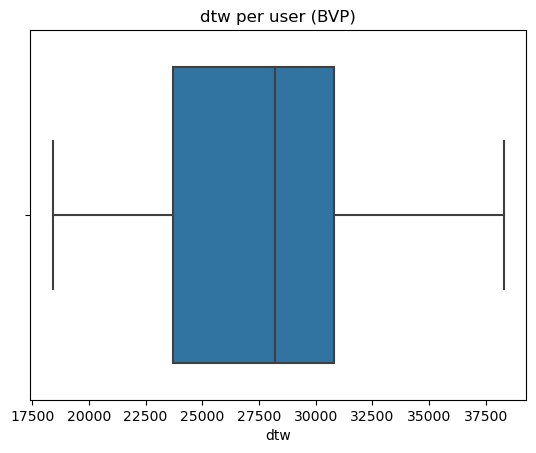

In [ ]:
dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
plot_heatmap_boxplot(
    data=dtws, signal=signal, measure_name="dtw", vmax=None, vmin=None, center=None
)


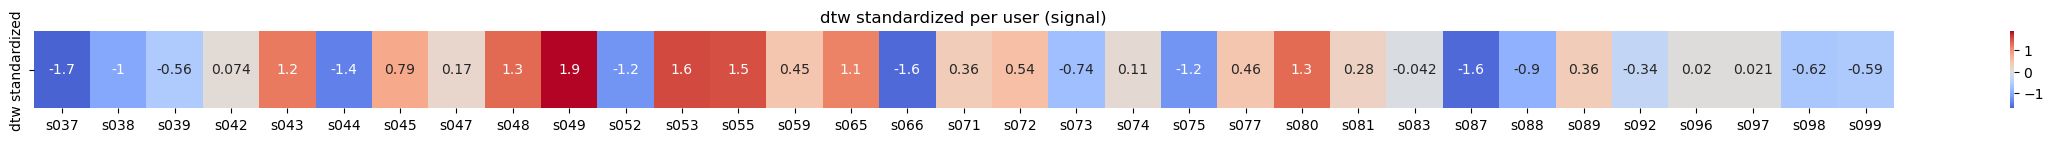

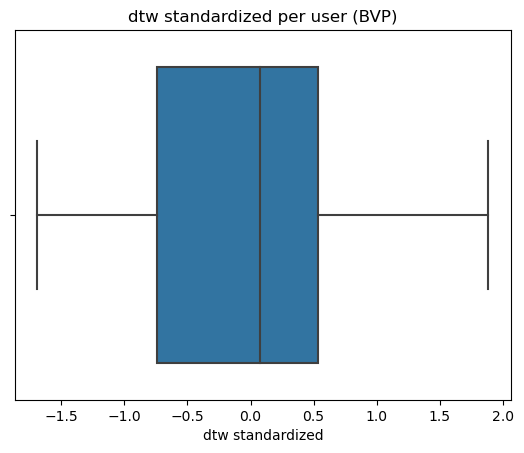

In [ ]:
from numpy import nanmean, nanstd

dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
dtws_stand = {
    user: (dtw - nanmean(list(dtws.values()))) / nanstd(list(dtws.values()))
    for user, dtw in dtws.items()
}
plot_heatmap_boxplot(
    data=dtws_stand,
    signal=signal,
    measure_name="dtw standardized",
    vmax=None,
    vmin=None,
    center=0,
)

### Per event and per user

In [127]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sys import path
path.append("../")
from src.utils.plots import plot_heatmap_boxplot

def run_dtw_calculation(
    physiological_data: dict, signal: str, n_jobs: int = -1, **kwargs
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    # Define a function that takes in a user and computes the DTW distance
    def compute_dtw(user, physiological_data, signal, session_name):
        x = (
            physiological_data[signal]["right"][user][session_name]
            .values.reshape(-1, 1)
        )
        y = (
            physiological_data[signal]["left"][user][session_name]
            .values.reshape(-1, 1)
        )
        return user, session_name, fastdtw(x=x, y=y, dist=kwargs.get("distance", euclidean))[0]

    # Use Parallel and delayed to run the function in parallel
    dtws = Parallel(n_jobs=n_jobs, backend='threading')(
        delayed(compute_dtw)(user, physiological_data, signal, session_name)
        for user in tqdm(user_list, desc="User progress", colour="blue")
        for session_name in tqdm(list(
            set(physiological_data[signal]["right"][user].keys())
            & set(physiological_data[signal]["left"][user].keys())
        ), desc='Session progress', colour='green')
    )

    # Convert the results to a dictionary
    return dtws


In [128]:
from warnings import warn
physiological_data_w_events = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
signal: str = 'BVP'
selected_keys = ['cognitive_load', 'baseline_1']
for side in ['left', 'right']:
    for user in experimento_info.index.get_level_values(0).unique():
        if user not in physiological_data[signal][side]:
            warn(f'User {user} not in {signal} {side} data')
            continue
        user_data: DataFrame = physiological_data[signal][side][user]
        user_experiment_info = experimento_info.loc[user]
        for event in user_experiment_info.index:
            if event in selected_keys:
                start, end = user_experiment_info.loc[event, ['start', 'end']]
                physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
            else:
                continue

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/1335996214.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/1335996214.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/1335996214.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
 

In [129]:
signal: str = "BVP"
dtws = run_dtw_calculation(
    physiological_data=physiological_data_w_events, signal=signal, n_jobs=-1
)


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:01<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:01<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

Session progress:   0%|          | 0/2 [00:00<?, ?it/s]

In [130]:
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    inverted: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    if inverted:
        df_to_save = df_to_save.T
    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()
    if df_to_save.shape[1] > 1:
        new_df = DataFrame(columns=['Value', 'Session'])
        for idx_uniques in df_to_save.index.unique():
            intermediate1 = df_to_save.loc[idx_uniques]
            intermediate2 = [idx_uniques for _ in range(len(intermediate1))]
            intermediate3 = DataFrame.from_dict({'Value': intermediate1, 'Session': intermediate2})
            new_df = new_df.append(intermediate3)
        boxplot(x='Value', y='Session', data=new_df)
    else:
        boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

new_dtws = defaultdict(dict)
for user, session_name, dtw in dtws:
    new_dtws[user][session_name] = dtw

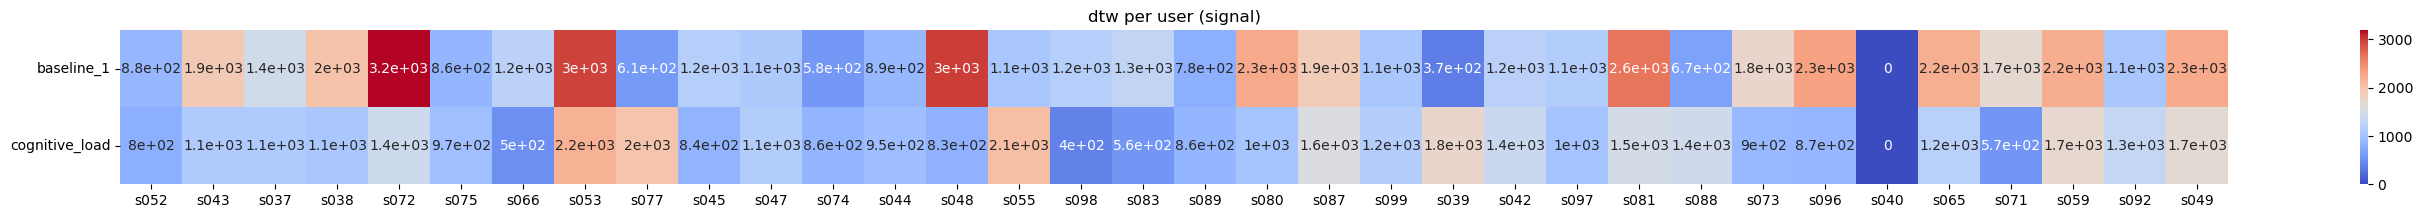

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/2508330802.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)
/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_87074/2508330802.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)


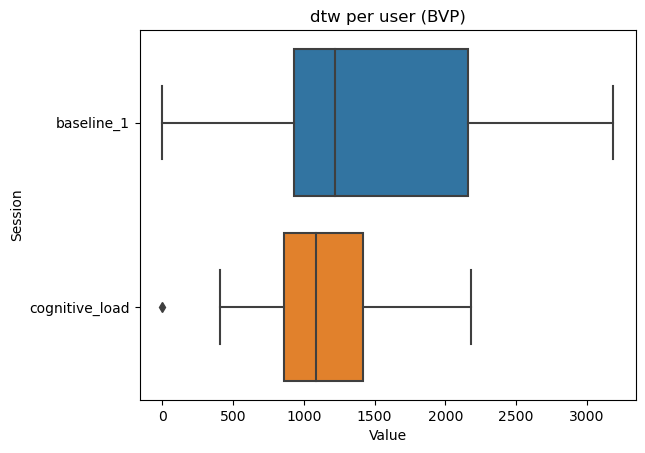

In [131]:


plot_heatmap_boxplot(
            data=new_dtws,
            signal=signal,
            measure_name="dtw",
            nested=True,
            vmax=None,
            vmin=None,
            center=None,
            inverted=True,
            data_name="usilaughs",
        )

<Axes: >

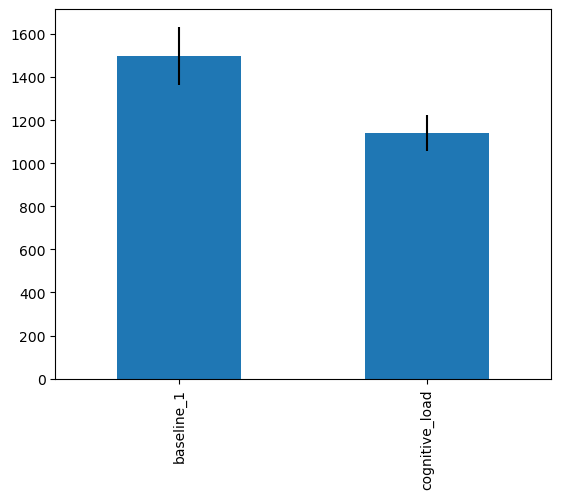

In [132]:
from numpy import sqrt
test = DataFrame(new_dtws)
means = test.mean(axis=1)
stds = test.std(axis=1)
ses = stds / sqrt(len(test.columns))
means.plot(yerr=ses, kind='bar')

# Weighted Dynamic Time Warping

When calculating the DTW per event, I am divind it by the event duration. This way, I can account for potential differences due to cognitive load being just shorter in duration.

In [5]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sys import path
path.append("../")
from src.utils.plots import plot_heatmap_boxplot

In [26]:
from joblib import Parallel, delayed

def run_dtw_calculation(physiological_data: dict, signal: str, n_jobs: int = -1, **kwargs):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    # Define a function that takes in a user and computes the DTW distance
    def compute_dtw(user, physiological_data, signal):
        x = physiological_data[signal]["right"][user].iloc[:, 0].values.reshape(-1, 1)
        y = physiological_data[signal]["left"][user].iloc[:, 0].values.reshape(-1, 1)
        return user, fastdtw(x=x, y=y, dist=kwargs.get("distance", euclidean))[0]/(len(x) if len(x) > 0 else 1)

    # Use Parallel and delayed to run the function in parallel
    dtws = Parallel(n_jobs=n_jobs)(
        delayed(compute_dtw)(user, physiological_data, signal)
        for user in tqdm(user_list, desc="User progress", colour="blue")
    )

    # Convert the results to a dictionary
    return dict(dtws)


## EDA

### Per user

In [11]:
signal: str = "EDA"
dtws = run_dtw_calculation(physiological_data=physiological_data, signal=signal, n_jobs=1)

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

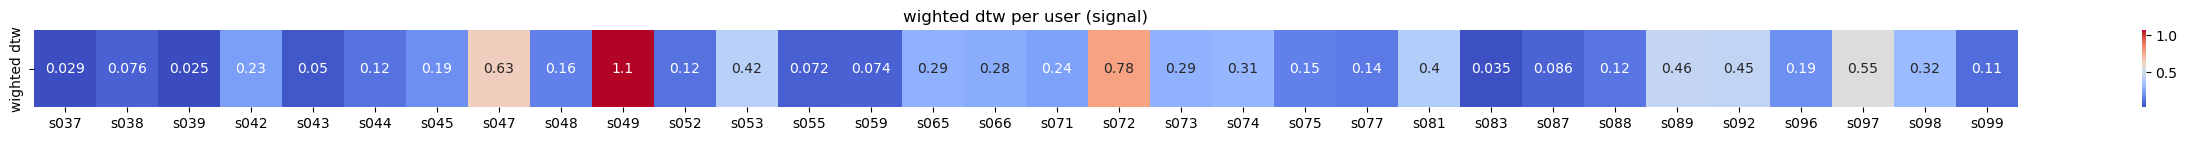

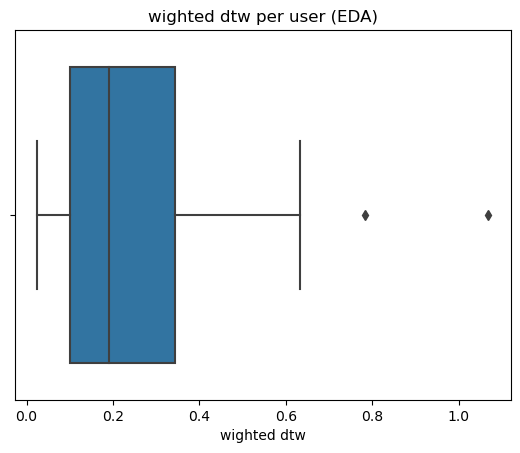

In [12]:
dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
plot_heatmap_boxplot(
    data=dtws,
    signal=signal,
    measure_name="wighted dtw",
    vmax=None,
    vmin=None,
    center=None,
    data_name="usilaughs",
)


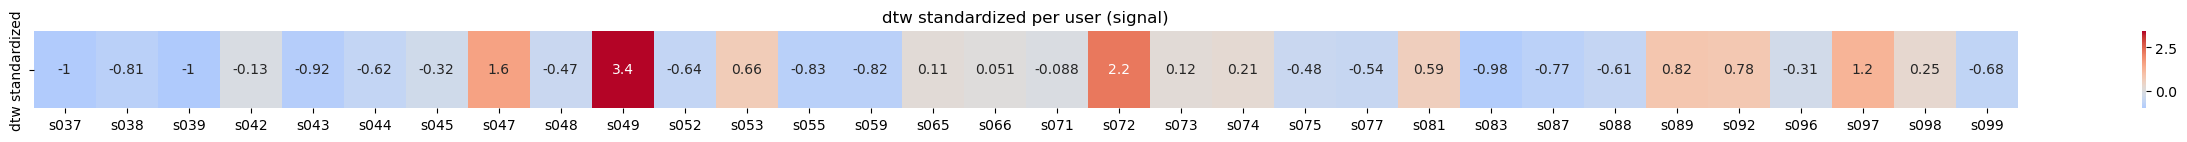

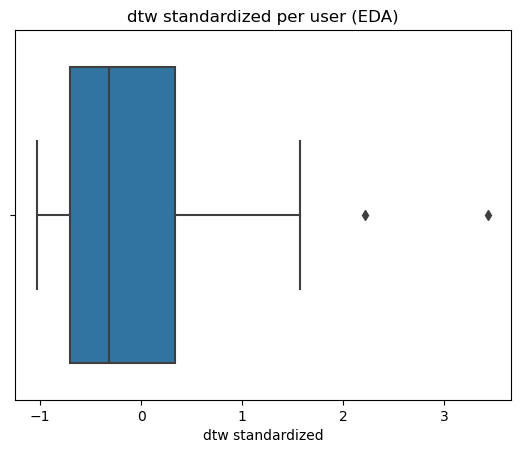

In [13]:
from numpy import nanmean, nanstd

dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
dtws_stand = {
    user: (dtw - nanmean(list(dtws.values()))) / nanstd(list(dtws.values()))
    for user, dtw in dtws.items()
}
plot_heatmap_boxplot(
    data=dtws_stand,
    signal=signal,
    measure_name="dtw standardized",
    vmax=None,
    vmin=None,
    center=0,
)


### Per event and per user

In [29]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sys import path

path.append("../")
from src.utils.plots import plot_heatmap_boxplot


def run_dtw_calculation(
    physiological_data: dict, signal: str, n_jobs: int = -1, **kwargs
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    # Define a function that takes in a user and computes the DTW distance
    def compute_dtw(user, physiological_data, signal, session_name):
        x = physiological_data[signal]["right"][user][session_name].values.reshape(
            -1, 1
        )
        y = physiological_data[signal]["left"][user][session_name].values.reshape(-1, 1)
        return (
            user,
            session_name,
            fastdtw(x=x, y=y, dist=kwargs.get("distance", euclidean))[0]
            / (len(x) if len(x) > 0 else 1),
        )

    # Use Parallel and delayed to run the function in parallel
    dtws = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(compute_dtw)(user, physiological_data, signal, session_name)
        for user in tqdm(user_list, desc="User progress", colour="blue")
        for session_name in list(
            set(physiological_data[signal]["right"][user].keys())
            & set(physiological_data[signal]["left"][user].keys())
        )
    )

    # Convert the results to a dictionary
    return dtws


In [18]:
from warnings import warn
physiological_data_w_events = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
signal: str = 'EDA'
selected_keys = ['cognitive_load', 'baseline_1']
for side in ['left', 'right']:
    for user in experimento_info.index.get_level_values(0).unique():
        if user not in physiological_data[signal][side]:
            warn(f'User {user} not in {signal} {side} data')
            continue
        user_data: DataFrame = physiological_data[signal][side][user]
        user_experiment_info = experimento_info.loc[user]
        for event in user_experiment_info.index:
            if event in selected_keys:
                start, end = user_experiment_info.loc[event, ['start', 'end']]
                physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
            else:
                continue

/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/994210659.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/994210659.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/994210659.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ph

In [19]:
signal: str = "EDA"
dtws = run_dtw_calculation(
    physiological_data=physiological_data_w_events, signal=signal, n_jobs=-1
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

In [32]:
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    inverted: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).sort_index().T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    if inverted:
        df_to_save = df_to_save.sort_index().T
    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()
    if df_to_save.shape[1] > 1:
        new_df = DataFrame(columns=['Value', 'Session'])
        for idx_uniques in df_to_save.index.unique():
            intermediate1 = df_to_save.loc[idx_uniques]
            intermediate2 = [idx_uniques for _ in range(len(intermediate1))]
            intermediate3 = DataFrame.from_dict({'Value': intermediate1, 'Session': intermediate2})
            new_df = new_df.append(intermediate3)
        boxplot(x='Value', y='Session', data=new_df)
    else:
        boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

new_dtws = defaultdict(dict)
for user, session_name, dtw in dtws:
    new_dtws[user][session_name] = dtw

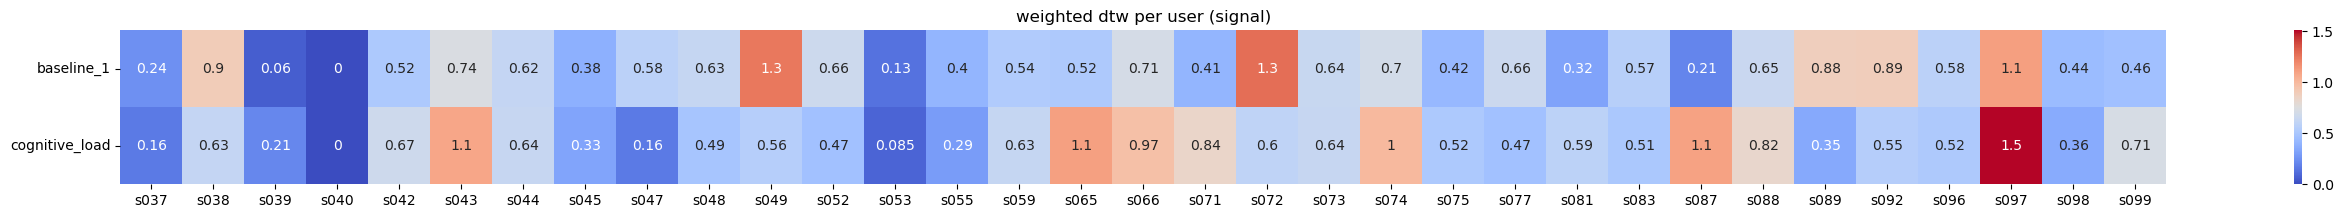

/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/803584418.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)
/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/803584418.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)


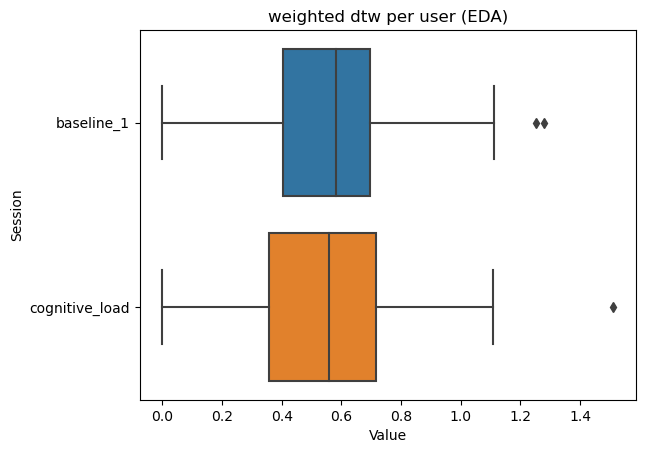

In [23]:


plot_heatmap_boxplot(
            data=new_dtws,
            signal=signal,
            measure_name="weighted dtw",
            nested=True,
            vmax=None,
            vmin=None,
            center=None,
            inverted=True,
            data_name="usilaughs",
        )

<AxesSubplot:>

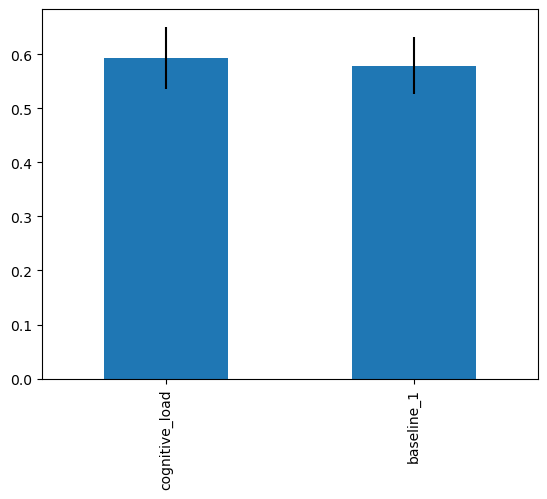

In [24]:
from numpy import sqrt
test = DataFrame(new_dtws)
means = test.mean(axis=1)
stds = test.std(axis=1)
ses = stds / sqrt(len(test.columns))
means.plot(yerr=ses, kind='bar')

## BVP

### Per user

In [27]:
signal: str = "BVP"
dtws = run_dtw_calculation(physiological_data=physiological_data, signal=signal, n_jobs=-1)

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

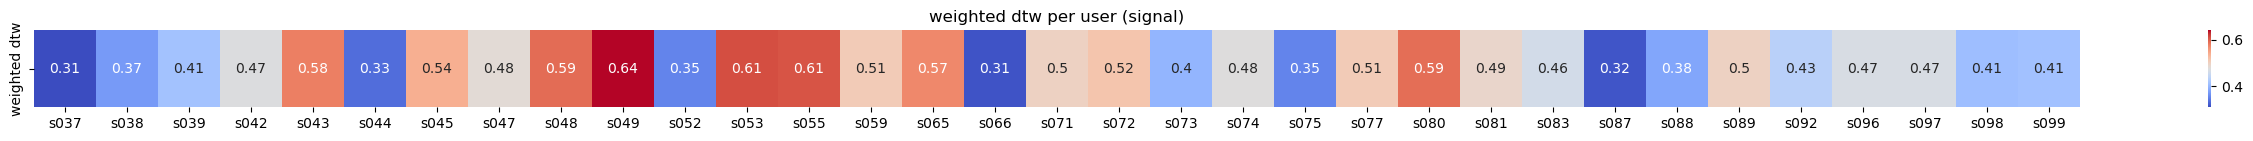

/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/803584418.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)


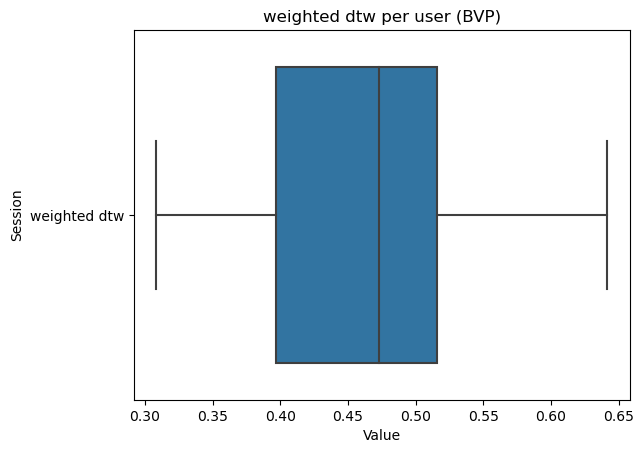

In [28]:
dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
plot_heatmap_boxplot(
    data=dtws,
    signal=signal,
    measure_name="weighted dtw",
    vmax=None,
    vmin=None,
    center=None,
    data_name="usilaughs",
)


### Per event and per user

In [30]:
from warnings import warn
physiological_data_w_events = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
signal: str = 'BVP'
selected_keys = ['cognitive_load', 'baseline_1']
for side in ['left', 'right']:
    for user in experimento_info.index.get_level_values(0).unique():
        if user not in physiological_data[signal][side]:
            warn(f'User {user} not in {signal} {side} data')
            continue
        user_data: DataFrame = physiological_data[signal][side][user]
        user_experiment_info = experimento_info.loc[user]
        for event in user_experiment_info.index:
            if event in selected_keys:
                start, end = user_experiment_info.loc[event, ['start', 'end']]
                physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
            else:
                continue

/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/1335996214.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/1335996214.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  physiological_data_w_events[signal][side][user][event] = user_data.loc[IndexSlice[:, start:end], :]
/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/1335996214.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
 

In [31]:
signal: str = "BVP"
dtws = run_dtw_calculation(
    physiological_data=physiological_data_w_events, signal=signal, n_jobs=-1
)


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

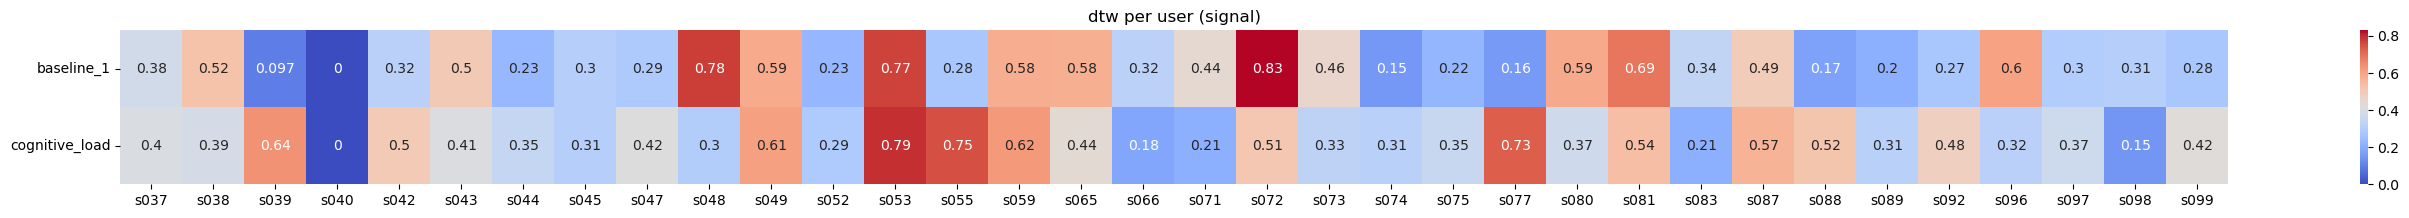

/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/803584418.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)
/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_38617/803584418.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(intermediate3)


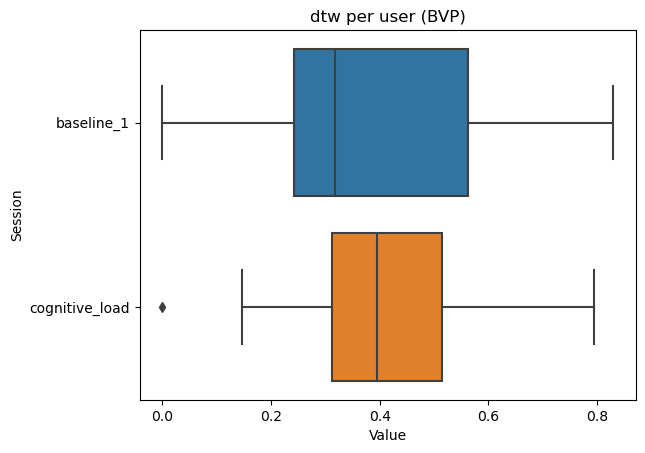

In [33]:


plot_heatmap_boxplot(
            data=new_dtws,
            signal=signal,
            measure_name="dtw",
            nested=True,
            vmax=None,
            vmin=None,
            center=None,
            inverted=True,
            data_name="usilaughs",
        )

<AxesSubplot:>

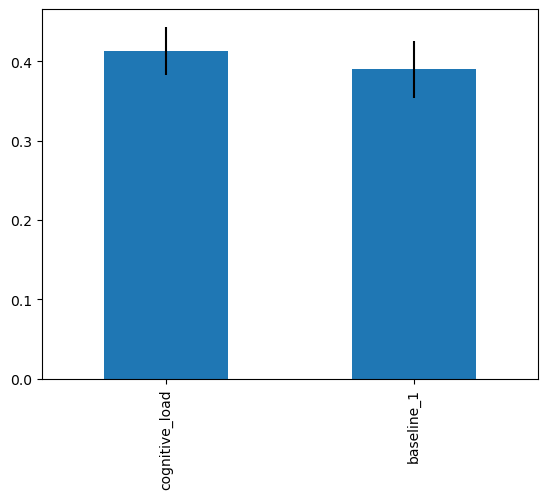

In [34]:
from numpy import sqrt
test = DataFrame(new_dtws)
means = test.mean(axis=1)
stds = test.std(axis=1)
ses = stds / sqrt(len(test.columns))
means.plot(yerr=ses, kind='bar')

# Coherence Analysis

## EDA

In [ ]:
from scipy.signal import coherence

In [ ]:
signal: str = "EDA"
time_scale: int = 20
users_left = physiological_data[signal]["left"].keys()
users_right = physiological_data[signal]["right"].keys()
user_list = list(set(users_left) & set(users_right))

cas = {
    user: coherence(
        x=physiological_data[signal]["right"][user].iloc[:, 0].values,
        y=physiological_data[signal]["left"][user].iloc[:, 0].values,
        fs=1.,
        window='hann',
        nperseg=None,
        noverlap=None,
        nfft=None,
        detrend='constant',
        axis=-1,
    )
    for user in tqdm(user_list, desc="User progress", colour='blue')
}


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
max_cca = {user: ca[1].max() for user, ca in cas.values() if len(ca[1]) > 0}

TypeError: object of type 'numpy.float64' has no len()

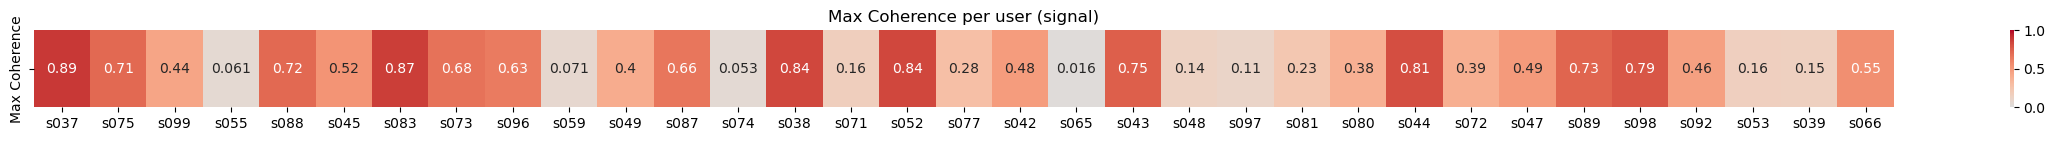

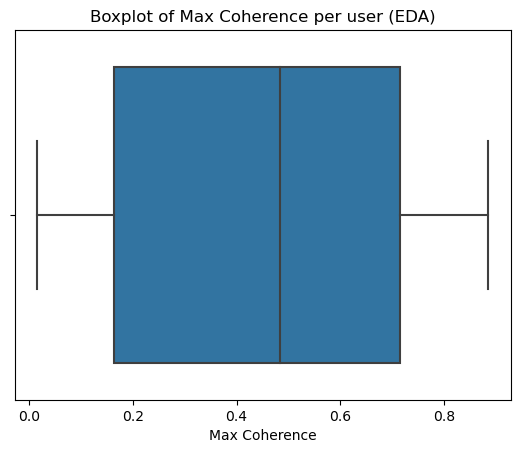

In [ ]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(max_cca)
df_to_save = DataFrame(df_to_save, columns=['Max Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    center=0,
    vmax=1,
    vmin=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Max Coherence per user (signal)")
savefig(f"../visualizations/user_max_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Max Coherence per user ({signal})")
savefig(f"../visualizations/user_max_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()


In [ ]:
avg_cca = {user: ca[1].mean() for user, ca in cas.values() if len(ca[1]) > 0}

TypeError: object of type 'numpy.float64' has no len()

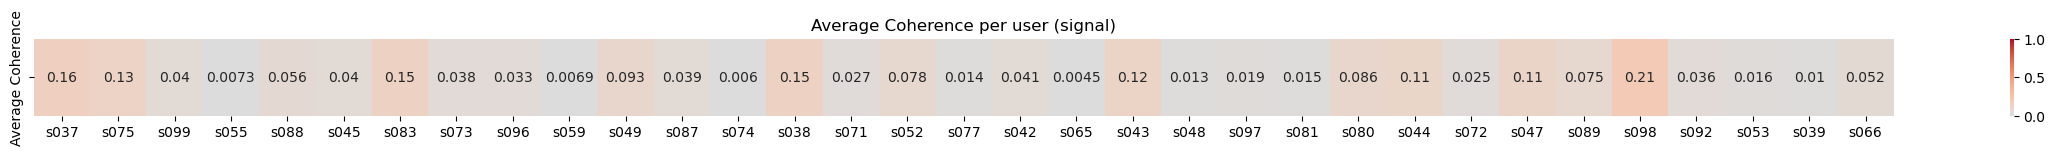

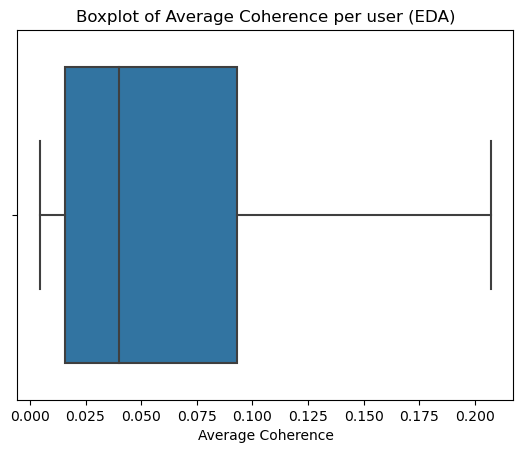

In [ ]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(avg_cca)
df_to_save = DataFrame(df_to_save, columns=['Average Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    vmax=1,
    vmin=0,
    center=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Average Coherence per user (signal)")
savefig(f"../visualizations/user_average_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Average Coherence per user ({signal})")
savefig(f"../visualizations/user_average_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()


## BVP

In [ ]:
from scipy.signal import coherence

In [ ]:
signal: str = "BVP"
time_scale: int = 20
users_left = physiological_data[signal]["left"].keys()
users_right = physiological_data[signal]["right"].keys()
user_list = list(set(users_left) & set(users_right))

cas = {
    user: coherence(
        x=physiological_data[signal]["right"][user].iloc[:, 0].values,
        y=physiological_data[signal]["left"][user].iloc[:, 0].values,
        fs=1.,
        window='hann',
        nperseg=None,
        noverlap=None,
        nfft=None,
        detrend='constant',
        axis=-1,
    )
    for user in tqdm(user_list, desc="User progress", colour='blue')
}


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
max_cca = {user: ca[1].max() for user, ca in cas.items() if len(ca[1]) > 0}

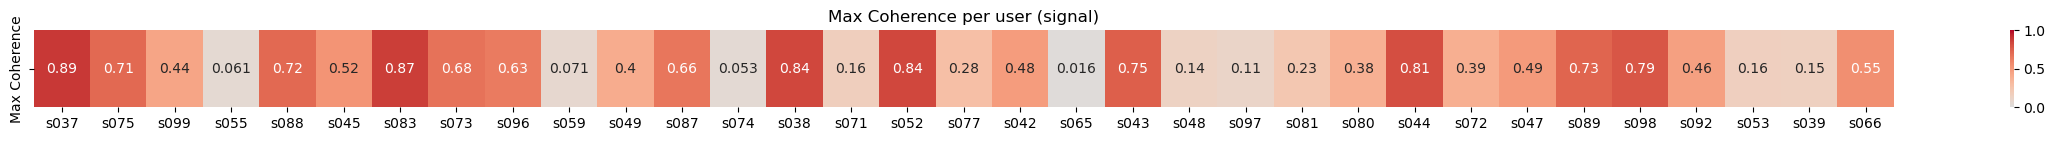

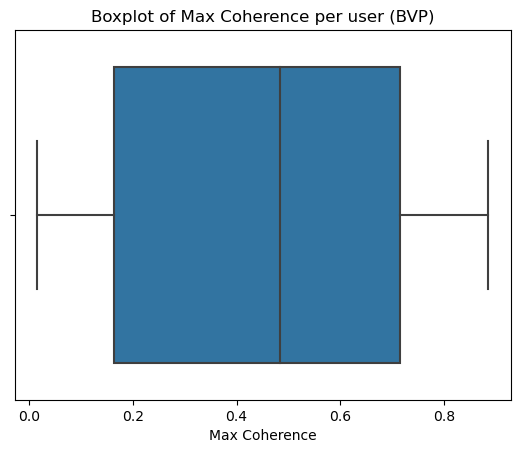

In [ ]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(max_cca)
df_to_save = DataFrame(df_to_save, columns=['Max Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    center=0,
    vmax=1,
    vmin=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Max Coherence per user (signal)")
savefig(f"../visualizations/user_max_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Max Coherence per user ({signal})")
savefig(f"../visualizations/user_max_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()


In [ ]:
avg_cca = {user: ca[1].mean() for user, ca in cas.items() if len(ca[1]) > 0}

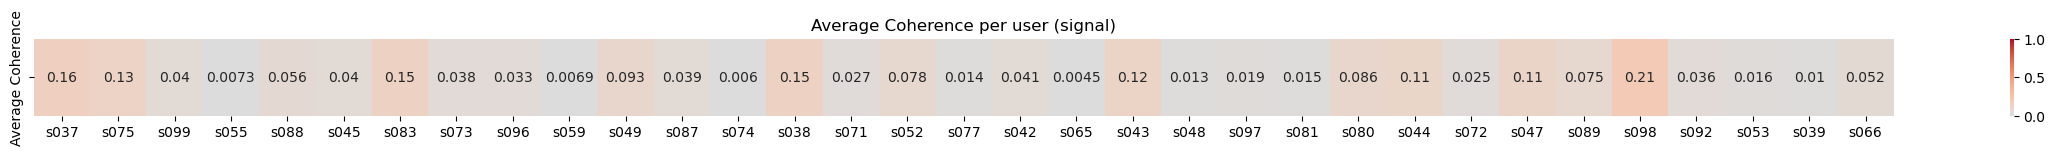

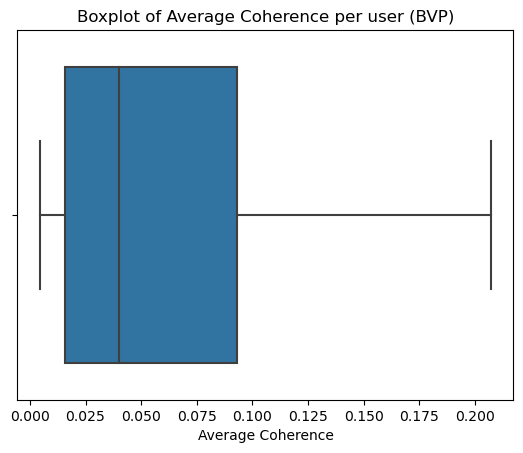

In [ ]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(avg_cca)
df_to_save = DataFrame(df_to_save, columns=['Average Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    vmax=1,
    vmin=0,
    center=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Average Coherence per user (signal)")
savefig(f"../visualizations/user_average_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Average Coherence per user ({signal})")
savefig(f"../visualizations/user_average_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()
